In [640]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt
from astropy import constants as const # import astropy constants
from CenterOfMass import CenterOfMass
from ReadFile import Read

In [641]:
class MassProfile:
# Class to define COM position and velocity properties 
# of a given galaxy and simulation snapshot

    def __init__(self, galaxy, snap):
        ''' 
        Class to calculate the mass enclosed by a given radius, Hernquist mass,
        and circular velocity.
         
        PARAMETERS
        ----------
        galaxy : `str`
        name of galaxy (i.e. MW,M31)
        snap : `int; 0 or 1`
        simulation timestamp
        '''
        # construct file name 
        ilbl = '000'+str(snap)
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+'.txt'
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             
        
        # store the particle masses, positions, and galaxy name
        self.m = self.data['m']
        self.x = self.data['x']
        self.y = self.data['y']
        self.z = self.data['z']
        self.gname = galaxy

    def MassEnclosed(self, ptype, r):
        '''
        Function that calculates the mass enclosed within each
        radius in the r array.
        inputs: ptype= particle types, r= array of radii magnitudes
        outputs: masses= array of masses
        '''
        # assign units to the radius values
        r = r*u.kpc

        # call COM class
        COM = CenterOfMass(self.filename, 2)
        pos_COM = COM.COM_P(0.1)

        # deifing mask to select for particle type
        type = np.where(self.data['type'] == ptype)
        pdata = self.data[type]  # data of specified component
        
        # get positions from data and subtract COM components
        x = pdata['x']*u.kpc-pos_COM[0]
        y = pdata['y']*u.kpc-pos_COM[1]
        z = pdata['z']*u.kpc-pos_COM[2]
        r1 = np.sqrt(x**2 + y**2 + z**2) # magnitude of particle position

        # array to store the mass enclosed by each radius value
        masses = np.zeros(len(r))
        
        for i in range(len(r)):
            # looping through the radius array 
            # mask for selecting particles within the given radius
            radius = np.where(r1 <= r[i])
            
            #pmass = self.data['m'][radius] # array of particle masses within given radius
            pmass = pdata['m'][radius]
            
            # sum enclosed particle masses
            m_sum = np.sum(pmass)
            masses[i] = m_sum # add summed mass to enclosed mass array

        # retrn array of masses as astropy quantities
        return masses*1e10*u.Msun

    def MassEnclosedTotal(self,r):
        '''
        Function that calculates the total mass eclosed by a radius.
        inputs: r = array of radii
        outputs: m_total = array of total mass at each radius value
        '''
        # condition to calculate total mass of M33 with no bulge
        if self.gname == 'M33':
            m_halo = self.MassEnclosed(1,r)
            m_disk = self.MassEnclosed(2,r)
 
            m_total = m_halo + m_disk

        # calculating total mass of MW and M31
        else:
            m_halo = self.MassEnclosed(1,r)
            m_disk = self.MassEnclosed(2,r)
            m_bulge = self.MassEnclosed(3,r)
            
            m_total = m_halo + m_disk + m_bulge

        return m_total
        
    def HernquistMass(self,R,a,mHalo):
        '''
        Function that calculates the Hernquist mass at a 
        given radius.
        inputs: R= radius, a= scale length, mHalo= mass of galaxy halo
        outputs: HernMass= Hernquist mass at R radius
        '''
        # breaking down equation into numerator and denominator
        num = mHalo*R**2
        den = (a+R)**2

        # Hernquist Mass
        HernMass = num/den

        return HernMass*u.Msun

    def CircularVelocity(self,ptype,r):
        '''
        Function that calculates the circular velocity of 
        any given galaxy component at specific radii.
        inputs: ptype= particle types, r= array of radii magnitudes
        outputs: v = array of circular velocities in km/s
        '''
        # define astropy gravitational constant
        G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)

        # find mass of a given component
        m = self.MassEnclosed(ptype,r)
        r = r *u.kpc # astropy quantity

        # calculating circular velocity
        v = np.sqrt(G*m/r) 

        return v

    def CircularVelocityTotal(self,r):
        '''
        Function that calculates the circular velocity of each galaxy.
        inputs: r= array of radii magnitudes
        outputs: v_total= total circular velocity of all components
        '''
        # define astropy gravitational constant
        G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        # total mass
        mtot = self.MassEnclosedTotal(r)

        # calculate total circular velocity
        v_total = np.sqrt(G*mtot/r)

        return v_total

    def HernquistVCirc(self,R,a,mHalo):
        '''
        Function that computes the circular speed using the Hernquist mass profile.
        inputs: R= radius, a= scale length, mHalo= mass of galaxy halo
        outputs: HernV= Hernquist circular velocity 
        '''
        # define astropy gravitational constant
        G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        # Hernquist mass 
        M = self.HernquistMass(R,a,mHalo)

        R = R*u.kpc # astropy quantity

        # calculate the Hernquist circular velocity
        HernV = np.sqrt(G*M/R)
        
        return HernV

        

In [642]:
# call class on all galaxies
MW = MassProfile("MW",0)
M31 = MassProfile("M31",0)
M33 = MassProfile("M33",0)

# define array of radii up until 30 kpc
r = np.arange(0.1,30.5,1.5)


/var/folders/9l/bypjqy711gb6pv49gxd3zk980000gn/T/ipykernel_66989/1129506510.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(r, np.log10(MW_halo.to_value()), color='limegreen',


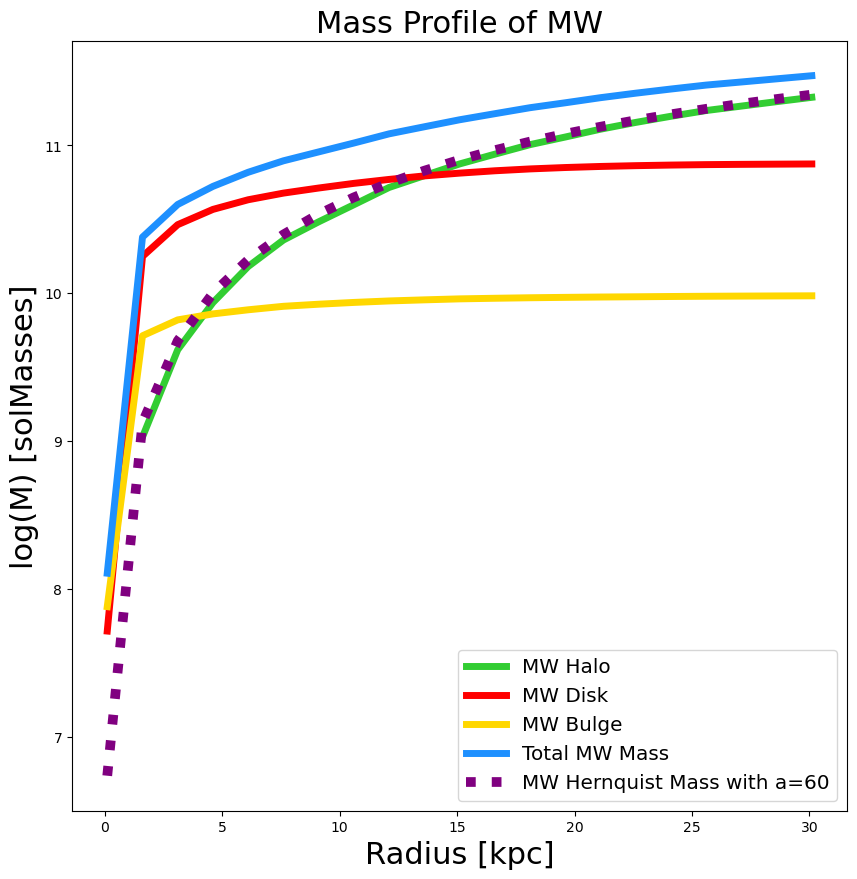

In [643]:
# find mass enclosed by radius values of each component
MW_halo = MW.MassEnclosed(1,r)
MW_disk = MW.MassEnclosed(2,r)
MW_bulge = MW.MassEnclosed(3,r)

# total mass enclosed
totalM = MW.MassEnclosedTotal(r) 

# Hernquist mass
mHalo = 1.975e12
HernM = MW.HernquistMass(r,60,mHalo)

# start plotting code
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot halo mass profile
plt.plot(r, np.log10(MW_halo.to_value()), color='limegreen', 
         linewidth=5, label='MW Halo')

# plot disk mass profile
plt.plot(r, np.log10(MW_disk.to_value()), color='red', 
         linewidth=5, label='MW Disk')

# plot bulge mass profile
plt.plot(r, np.log10(MW_bulge.to_value()), color='gold', 
         linewidth=5, label='MW Bulge')

# plot total mass profile
plt.plot(r, np.log10(totalM.to_value()), color='dodgerblue', 
         linewidth=5, label='Total MW Mass')

# plot Hernquist mass profile
plt.plot(r, np.log10(HernM.to_value()), color='purple', 
         linewidth=7, linestyle=':',label='MW Hernquist Mass with a=60')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('log(M) [solMasses]', fontsize=22)

# add title to plot
plt.title('Mass Profile of MW', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('MP_MW.png')

/var/folders/9l/bypjqy711gb6pv49gxd3zk980000gn/T/ipykernel_66989/794516552.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(r, np.log10(M31_halo.to_value()), color='limegreen',


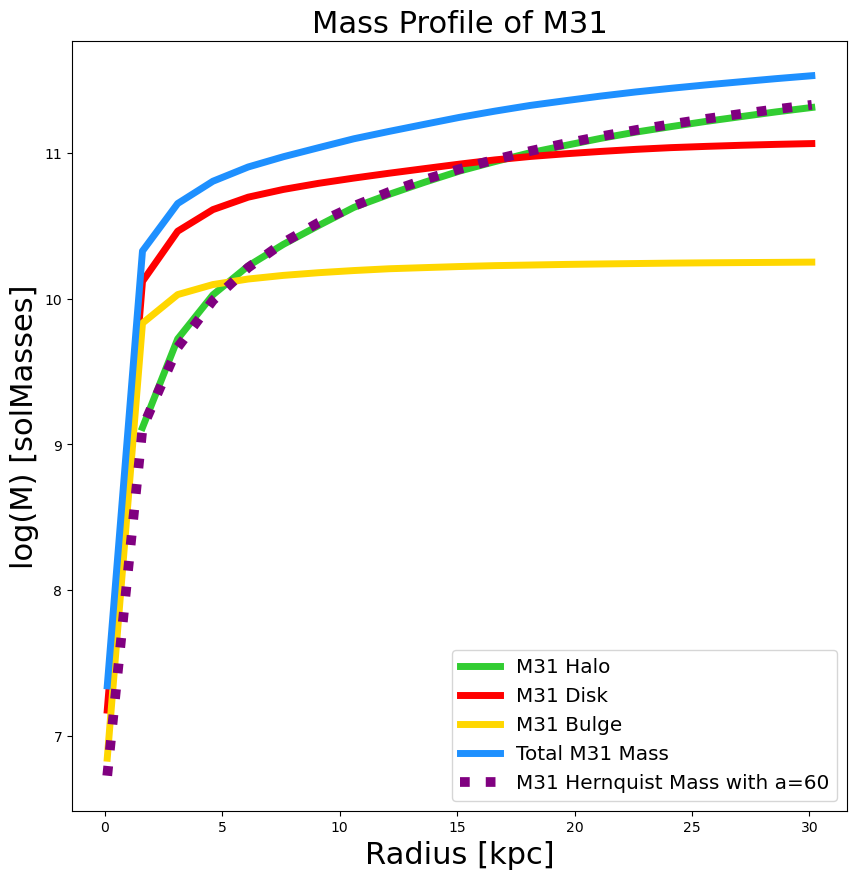

In [644]:
M31_halo = M31.MassEnclosed(1,r)
M31_disk = M31.MassEnclosed(2,r)
M31_bulge = M31.MassEnclosed(3,r)
totalM = M31.MassEnclosedTotal(r)

mHalo = 1.921e12
HernM = M31.HernquistMass(r,60,mHalo)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(r, np.log10(M31_halo.to_value()), color='limegreen', 
         linewidth=5, label='M31 Halo')

plt.plot(r, np.log10(M31_disk.to_value()), color='red', 
         linewidth=5, label='M31 Disk')

plt.plot(r, np.log10(M31_bulge.to_value()), color='gold', 
         linewidth=5, label='M31 Bulge')

plt.plot(r, np.log10(totalM.to_value()), color='dodgerblue', 
         linewidth=5, label='Total M31 Mass')

plt.plot(r, np.log10(HernM.to_value()), color='purple', 
         linewidth=7, linestyle=':',label='M31 Hernquist Mass with a=60')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('log(M) [solMasses]', fontsize=22)

# add label
plt.title('Mass Profile of M31', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('MP_M31.png')

/var/folders/9l/bypjqy711gb6pv49gxd3zk980000gn/T/ipykernel_66989/117496700.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(r, np.log10(M33_halo.to_value()), color='limegreen',


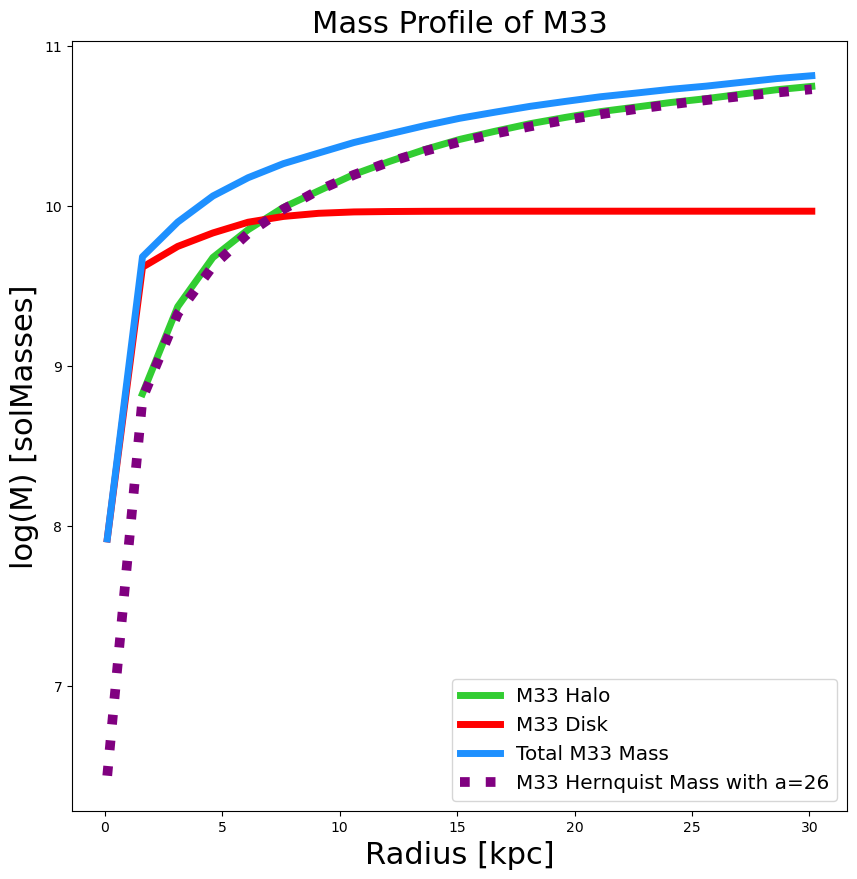

In [645]:
M33_halo = M33.MassEnclosed(1,r)
M33_disk = M33.MassEnclosed(2,r)
totalM = M33.MassEnclosedTotal(r)

mHalo = 0.187e12
HernM = M33.HernquistMass(r,26,mHalo)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(r, np.log10(M33_halo.to_value()), color='limegreen', 
         linewidth=5, label='M33 Halo')

plt.plot(r, np.log10(M33_disk.to_value()), color='red', 
         linewidth=5, label='M33 Disk')

plt.plot(r, np.log10(totalM.to_value()), color='dodgerblue', 
         linewidth=5, label='Total M33 Mass')

plt.plot(r, np.log10(HernM.to_value()), color='purple', 
         linewidth=7, linestyle=':',label='M33 Hernquist Mass with a=26')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('log(M) [solMasses]', fontsize=22)

# add label
plt.title('Mass Profile of M33', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('MP_M33.png')

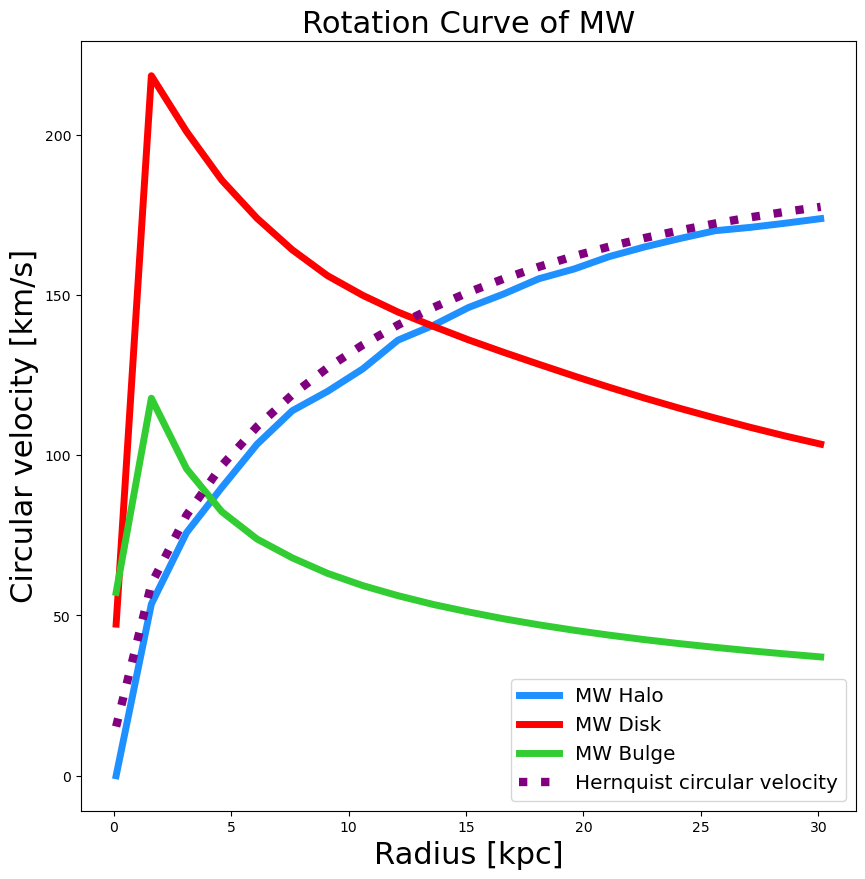

In [658]:
MW_vhalo = MW.CircularVelocity(1,r)
MW_vdisk = MW.CircularVelocity(2,r)
MW_vbulge = MW.CircularVelocity(3,r)

mHalo = 1.975e12
HernV = MW.HernquistVCirc(r,60,mHalo)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(r, MW_vhalo, color='dodgerblue', 
         linewidth=5, label='MW Halo')

plt.plot(r, MW_vdisk, color='red', 
         linewidth=5, label='MW Disk')

plt.plot(r, MW_vbulge, color='limegreen', 
         linewidth=5, label='MW Bulge')

plt.plot(r, HernV, color='purple', 
         linewidth=6, linestyle=":",label='Hernquist circular velocity')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Circular velocity [km/s]', fontsize=22)

# add label
plt.title('Rotation Curve of MW', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('RC_MW.png')

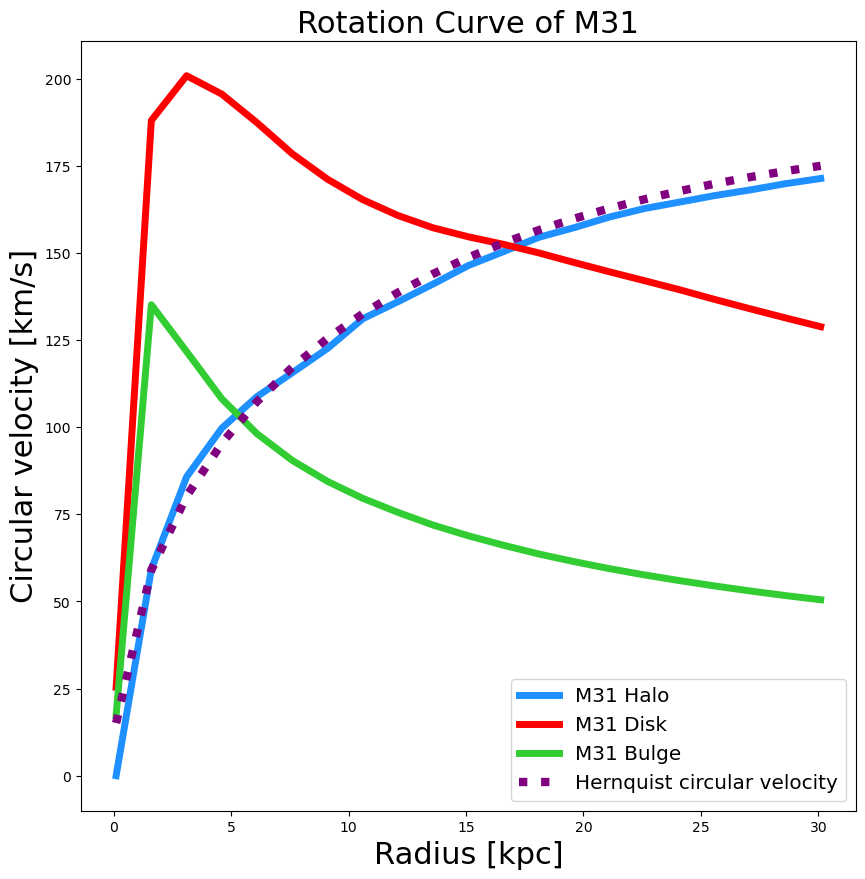

In [660]:
M31_vhalo = M31.CircularVelocity(1,r)
M31_vdisk = M31.CircularVelocity(2,r)
M31_vbulge = M31.CircularVelocity(3,r)

mHalo = 1.921e12
HernV = M31.HernquistVCirc(r,60,mHalo)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(r, M31_vhalo, color='dodgerblue', 
         linewidth=5, label='M31 Halo')

plt.plot(r, M31_vdisk, color='red', 
         linewidth=5, label='M31 Disk')

plt.plot(r, M31_vbulge, color='limegreen', 
         linewidth=5, label='M31 Bulge')

plt.plot(r, HernV, color='purple', 
         linewidth=6, linestyle=":",label='Hernquist circular velocity')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Circular velocity [km/s]', fontsize=22)

# add label
plt.title('Rotation Curve of M31', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('RC_M31.png')

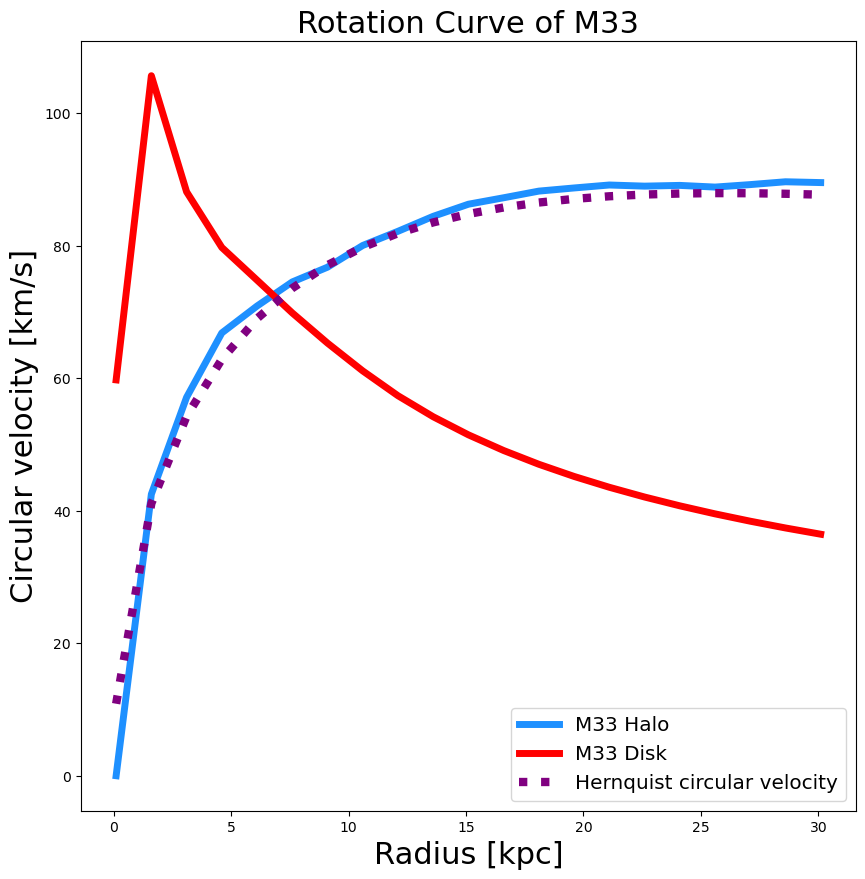

In [662]:
M33_vhalo = M33.CircularVelocity(1,r)
M33_vdisk = M33.CircularVelocity(2,r)

mHalo = 0.187e12
HernV = M33.HernquistVCirc(r,26,mHalo)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.plot(r, M33_vhalo, color='dodgerblue', 
         linewidth=5, label='M33 Halo')

plt.plot(r, M33_vdisk, color='red', 
         linewidth=5, label='M33 Disk')

plt.plot(r, HernV, color='purple', 
         linewidth=6, linestyle=":",label='Hernquist circular velocity')

# Add axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Circular velocity [km/s]', fontsize=22)

# add label
plt.title('Rotation Curve of M33', fontsize=22)

#adjust tick label font size
label_size = 22

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# save figure
plt.savefig('RC_M33.png')